# Complete Flight Analysis

### Import raw Airline Data

In [1]:
# Import Dependencies

import pandas as pd
import numpy as np
from pathlib import Path

In [ ]:
# Select relevant Columns

col_list = [
    'Flight_Number_Operating_Airline',
    'Operating_Airline ',
    'FlightDate',
    'Origin',
    'OriginCityName',
    'CRSDepTime',
    'DepTime', 
    'Dest',
    'DestCityName',
    'CRSArrTime',
    'ArrTime',
    'ArrDelayMinutes',
    'DepDelayMinutes',
    'CarrierDelay',
    'WeatherDelay',
    'NASDelay',
    'SecurityDelay',
    'LateAircraftDelay',
    'Cancelled',
    'CancellationCode'
    ]

In [ ]:
# Create blank master DF

messy_flight_df = pd.DataFrame()

In [ ]:
# import full year into DF

twenty18 = pd.DataFrame()
for j in range(1,13):
    file = Path(f'../archive/raw/Flights_2018_{j}.csv')
    import_df = pd.read_csv(file,low_memory=False,engine='c')
    twenty18 = pd.concat([twenty18,import_df],ignore_index=True)

In [ ]:
# narrow DF down to relevant columns
twenty18=twenty18[col_list]

In [ ]:
# # Create a checkpoint
# twenty18.to_csv('Resources/2018_raw.csv')

In [ ]:
# import full year into DF

twenty19 = pd.DataFrame()
for j in range(1,13):
    file = Path(f'../archive/raw/Flights_2019_{j}.csv')
    import_df = pd.read_csv(file,low_memory=False,engine='c')
    twenty19 = pd.concat([twenty19,import_df],ignore_index=True)

In [ ]:
# narrow DF down to relevant columns
twenty19=twenty19[col_list]

In [ ]:
# # Create a checkpoint
# twenty19.to_csv('Resources/2019_raw.csv')

In [ ]:
# import full year into DF

twenty20 = pd.DataFrame()
for j in range(1,13):
    file = Path(f'../archive/raw/Flights_2020_{j}.csv')
    import_df = pd.read_csv(file,low_memory=False,engine='c')
    twenty20 = pd.concat([twenty20,import_df],ignore_index=True)

In [ ]:
# narrow DF down to relevant columns
twenty20=twenty20[col_list]

In [ ]:
# # Create a checkpoint

# twenty20.to_csv('Resources/2020_raw.csv')

In [ ]:
# import full year into DF

twenty21 = pd.DataFrame()
for j in range(1,13):
    file = Path(f'../archive/raw/Flights_2021_{j}.csv')
    import_df = pd.read_csv(file,low_memory=False,engine='c')
    twenty21 = pd.concat([twenty21,import_df],ignore_index=True)

In [ ]:
# narrow DF down to relevant columns
twenty21=twenty21[col_list]

In [ ]:
# # Create a checkpoint
# twenty21.to_csv('Resources/2021_raw.csv')

In [ ]:
# import full year into DF

twenty22 = pd.DataFrame()
for j in range(1,8):
    file = Path(f'../archive/raw/Flights_2022_{j}.csv')
    import_df = pd.read_csv(file,low_memory=False,engine='c')    
    twenty22 = pd.concat([twenty22,import_df],ignore_index=True)

In [ ]:
# narrow DF down to relevant columns
twenty22=twenty22[col_list]

In [ ]:
# # Create a checkpoint
# twenty22.to_csv('Resources/2022_raw.csv')

In [ ]:
# Combine all years into one DF

messy_flight_df = pd.concat([twenty18,twenty19,twenty20,twenty21,twenty22],axis=0)

##### Create Target and Classifier columns

In [ ]:
# Making new binary column that tracks delay for both arr and dep

arr_dep_delayed = (messy_flight_df['ArrDelayMinutes']>0) | (messy_flight_df['DepDelayMinutes']>0)

messy_flight_df['Delayed'] = np.where(arr_dep_delayed, 1, 0)

In [ ]:
# Creates an integer coded target column for the Machine learning model 

on_time = (messy_flight_df['Delayed']==0) & (messy_flight_df['Cancelled']==0)
delayed = messy_flight_df['Delayed']==1
cancelled = messy_flight_df['Cancelled']==1

messy_flight_df['Target'] = np.where(on_time, '0', np.where(delayed,'1', np.where(cancelled,'2','')))

In [ ]:
# Function to clean the values in certain columns to a readable military datetime format

def mil_time_converter (series):
    # converts the string into a military time format
    series = series.apply(lambda x: f'{(int(x) // 100):02d}:{(int(x) % 100):02d}' if pd.notnull(x) else x)
    # Convert string to correct midnight format
    series = series.apply(lambda x: '00:00' if x == '24:00' else x)
    # Converts values into datetime object
    series = series.apply(lambda x: pd.to_datetime(x,format='%H:%M').strftime('%H:%M') if pd.notnull(x) else x)
    return series

# have not run this for production but should be faster
def mil_time_converter_faster (series):
    return series.apply(lambda x: pd.to_datetime(f'{(int(x) // 100):02d}:{(int(x) % 100):02d}', format='%H:%M')
        .replace(hour=0) if x == '2400' else pd.to_datetime(f'{(int(x) // 100):02d}:{(int(x) % 100):02d}', format='%H:%M') 
        if pd.notnull(x) else x)

In [ ]:
# Convert Arrival and Departure times to military format
mil_time_cols = ['ArrTime','CRSArrTime','DepTime','CRSDepTime']

for col in mil_time_cols:
    messy_flight_df[col]=mil_time_converter(messy_flight_df[col])

In [ ]:
# Convert FlightDate to datetime object

messy_flight_df['FlightDate'] = messy_flight_df['FlightDate'].apply(lambda x: pd.to_datetime(x) if pd.notnull(x) else x)

#### Export combined data csv

In [ ]:
messy_flight_df.to_csv('Resources/COMPLETE_Flights.csv')

### Create, Format, and Export Tables for Database

In [134]:
# Either imports if starting from new session or makes a copy of DF for cleaning
try:
    if messy_flight_df is not None:
        messy_flight_df = messy_flight_df
except NameError:
    # will only run if checkpoint is created
    messy_flight_path = Path('Resources/COMPLETE2.csv')
    messy_flight_df = pd.read_csv(messy_flight_path,index_col=0)

#### Airlines Table

In [ ]:
# import airlines csv from resources

airlines_df_path = Path('Resources/Airlines.csv')
airlines_cleanup_df = pd.read_csv(airlines_df_path)

In [ ]:
# Rename columns

airlines_cleanup_df.rename(columns={
    'Code':'Airline_Code',
    'Description':'Airline_Name'},inplace=True)

In [ ]:
# Confirm DB changes

airlines_cleanup_df

In [ ]:
# Export cleaned Dataframe to csv to use as Table

cleaned_airlines_path = Path('Resources/Complete_Airline_Table.csv')
airlines_cleanup_df.to_csv(cleaned_airlines_path)

#### Flights Table

In [ ]:
# create a list of columns from messy_flight_df to make Flight DF

flights_columns_list = [
    'Flight_Number_Operating_Airline',
    'Operating_Airline ',
    'Origin',
    'Dest',
    'FlightDate',
    'CRSDepTime', 
    'CRSArrTime',
    'DepTime', 
    'ArrTime',
    'Delayed',
    'Cancelled',
    'Target'
    ]

In [ ]:
# Create a Flights DF

Flights_df = messy_flight_df[flights_columns_list]

In [ ]:
# Rename Columns
Flights_df = Flights_df.rename(columns={
            'Flight_Number_Operating_Airline':'Airline_Flight_Number',
            'Operating_Airline ':'Operating_Airline',
            'Origin':'Origin_Airport',
            'Dest':'Destination_Airport',
            'FlightDate':'Flight_Date',
            'CRSDepTime':'Scheduled_Departure_Time',
            'CRSArrTime':'Scheduled_Arrival_Time',
            'DepTime':'Departure_Time',
            'ArrTime':'Arrival_Time'}).copy()

In [ ]:
# Confirm changes for DB

Flights_df

In [ ]:
# Export cleaned Dataframe to csv to use as Table

cleaned_flight_path = Path('Resources/Complete_Flights_Table.csv')
Flights_df.to_csv(cleaned_flight_path)

#### Delayed Flights Table

In [ ]:
# create a list of columns from messy_flight_df to make Delayed Flight DF


delayed_columns_list = [
    'Flight_Number_Operating_Airline',
    'FlightDate',
    'CRSArrTime',
    'ArrDelayMinutes',
    'CRSDepTime',
    'DepDelayMinutes',
    'CarrierDelay',
    'WeatherDelay',
    'NASDelay',
    'SecurityDelay',
    'LateAircraftDelay'
]

In [ ]:
# Create the Delayed Flights DF


Delayed_Flights_df = messy_flight_df.loc[delayed][delayed_columns_list].copy()

In [ ]:
# Create a list of columns that need converting to a datetime format

time_interval_columns = [
    'ArrDelayMinutes',
    'DepDelayMinutes',
    'CarrierDelay',
    'WeatherDelay',
    'NASDelay',
    'SecurityDelay',
    'LateAircraftDelay'
    ]

In [ ]:
### ONLY USE FOR VISUALIZATION AND TABLE CREATION TIMEDELTA CONVERSION GETS REVERSED FOR ML MODEL

# Format those columns as a time delta

for col in time_interval_columns:
    Delayed_Flights_df[col]=pd.to_timedelta(Delayed_Flights_df[col],unit='m')
    # Some times convert to NaT - fill values to 0 days
    Delayed_Flights_df[col] = Delayed_Flights_df[col].fillna(pd.Timedelta(seconds=0))

In [ ]:
# Rename Columns
Delayed_Flights_df = Delayed_Flights_df.rename(columns={
            'Flight_Number_Operating_Airline':'Airline_Flight_Number',
            'FlightDate':'Flight_Date',
            'CRSArrTime':'Scheduled_Arrival_Time',
            'ArrDelayMinutes':'Arrival_Delayed_Minutes',
            'CRSDepTime':'Scheduled_Departure_Time',
            'DepDelayMinutes':'Departure_Delayed_Minutes',
            'CarrierDelay':'Carrier_Delay_Minutes',
            'WeatherDelay':'Weather_Delay_Minutes',
            'NASDelay':'NAS_Delay_Minutes',
            'SecurityDelay':'Security_Delay_Minutes',
            'LateAircraftDelay':'Late_Aircraft_Delay_Minutes'}).copy()

In [ ]:
# Confirm Changes for final Table
Delayed_Flights_df

In [ ]:
# Export cleaned Dataframe to csv to use as Table

cleaned_delay_path = Path('Resources/Complete_Delayed_Flights_Table.csv')
Delayed_Flights_df.to_csv(cleaned_delay_path)

#### Airport Codes Table

In [19]:
# create a list of columns from messy_flight_df to make Airport Codes DF

airport_codes_list = [
    'Origin',
    'OriginCityName',
]

In [ ]:
# Create the Airport Codes DF

Airport_Codes_df = messy_flight_df[airport_codes_list].copy()

In [ ]:
# get only the Unique Origin Airport Codes
Airport_Codes_df = Airport_Codes_df.drop_duplicates(subset=['Origin'])

In [ ]:
# Split City and State to create columns for Table

Airport_Codes_df[['Airport_City','Airport_State']] = Airport_Codes_df['OriginCityName'].str.split(', ',expand=True)

In [ ]:
# Remove unnecesary Column

Airport_Codes_df = Airport_Codes_df.drop(columns=['OriginCityName'])

In [ ]:
# Clean the index

Airport_Codes_df.reset_index(drop=True,inplace=True)

In [ ]:
# Rename Columns

Airport_Codes_df = Airport_Codes_df.rename(columns={'Origin':'Airport_Code'})

In [ ]:
# Confirm DB changes

Airport_Codes_df

In [ ]:
# Export cleaned Dataframe to csv to use as Table

cleaned_airport_codes_path = Path('Resources/Complete_Airport_Codes.csv')
Airport_Codes_df.to_csv(cleaned_airport_codes_path)

#### Cancelled Flights Table

In [ ]:
# create a list of columns from messy_flight_df to make Cancelled Flights DF

cancelled_flights_list = [
    'Flight_Number_Operating_Airline',
    'Operating_Airline ',
    'Origin',
    'Dest',
    'FlightDate',
    'CancellationCode'
]

In [ ]:
# Create the Cancelled Flights DF

Cancelled_Flights_df = messy_flight_df.loc[cancelled][cancelled_flights_list].copy()

In [ ]:
# Rename Columns

Cancelled_Flights_df.rename(columns={'Flight_Number_Operating_Airline':'Airline_Flight_Number',
                                     'Operating_Airline ':'Operating_Airline',
                                     'Origin':'Origin_Airport',
                                     'Dest':'Destination_Airport',
                                     'CancellationCode':'Cancellation_Code',
                                     'FlightDate':'Flight_Date'},
                            inplace=True)

In [ ]:
# Confirm DB changes

Cancelled_Flights_df

In [ ]:
# Export cleaned Dataframe to csv to use as Table

cancelled_flight_path = Path('Resources/Complete_Cancelled_Flights_Table.csv')
Cancelled_Flights_df.to_csv(cancelled_flight_path)

### Prep for Model

In [2]:
### USE IF CHECKPOINT WAS CREATED

# Loads the Complete Flights csv

ml_df = pd.read_csv('Resources/COMPLETE2.csv', low_memory=False)

In [3]:
# Select columns that best apply to fitting the ML Model

ml_cols = [
    'Operating_Airline ',
    'Origin',
    'Dest',
    'FlightDate',
    'CRSArrTime',
    'CRSDepTime',
    'Target',
    'CarrierDelay',
    'WeatherDelay',
    'NASDelay',
    'SecurityDelay',
    'LateAircraftDelay',
    'CancellationCode'
]

ml_df = ml_df[ml_cols].copy()


In [4]:
# Rename the columns

ml_df = ml_df.rename(columns={
    'Operating_Airline ': 'Operating_Airline',
    'Origin': 'Origin_Airport',
    'Dest': 'Destination_Airport',
    'FlightDate': 'Flight_Date',
    'CRSArrTime': 'Scheduled_Arrival_Time',
    'CRSDepTime': 'Scheduled_Departure_Time',
    'CarrierDelay': 'Carrier_Delay_Minutes',
    'WeatherDelay': 'Weather_Delay_Minutes',
    'NASDelay': 'NAS_Delay_Minutes',
    'SecurityDelay': 'Security_Delay_Minutes',
    'LateAircraftDelay': 'Late_Aircraft_Delay_Minutes',
    'CancellationCode': 'Cancellation_Code'
})

In [5]:
# split the Date into separate pieces 

ml_df['Year'] = pd.to_datetime(ml_df['Flight_Date']).dt.year
ml_df['Month'] = pd.to_datetime(ml_df['Flight_Date']).dt.month
ml_df['Day'] = pd.to_datetime(ml_df['Flight_Date']).dt.day
ml_df['Weekday'] = pd.to_datetime(ml_df['Flight_Date']).dt.dayofweek

In [6]:
# Split the Military time into Hours and Minutes

ml_df[['Arrival_Hour','Arrival_Minute']]=ml_df['Scheduled_Arrival_Time'].str.split(':',expand=True)
ml_df[['Departure_Hour','Departure_Minute']]=ml_df['Scheduled_Departure_Time'].str.split(':',expand=True)

In [7]:
# Make columns that track reasons for both delays and cancellations to a binary

def check_condition(delay_col, cancel_code):
    
    condition = ((ml_df[delay_col] > 0) | (ml_df['Cancellation_Code'] == cancel_code))
    
    return condition

carrier = check_condition('Carrier_Delay_Minutes', 'A')
bad_weather = check_condition('Weather_Delay_Minutes', 'B')
NAS = check_condition('NAS_Delay_Minutes', 'C')
security = check_condition('Security_Delay_Minutes', 'D')
late_aircraft = (ml_df['Late_Aircraft_Delay_Minutes'] > 0)

ml_df['Carrier_Issue'] = np.where(carrier, 1, 0)
ml_df['Bad_Weather'] = np.where(bad_weather, 1, 0)
ml_df['NAS'] = np.where(NAS, 1, 0)
ml_df['Security_Issue'] = np.where(security, 1, 0)
ml_df['Late_Aircraft'] = np.where(security, 1, 0)

In [8]:
# Create function to output encoding dictionaries 

def encoder (MasterDF, ColName, Dictionary):
    uni_row_vals =[MasterDF[ColName].unique()][0]
    for x in range(len(uni_row_vals)):
        Dictionary[uni_row_vals[x]] = x

In [9]:
# Integer encode Origin and Destination airports

loc_dict = {}
encoder(ml_df, 'Origin_Airport', loc_dict)
ml_df['Origin_Airport'] = ml_df['Origin_Airport'].apply(lambda x: loc_dict[x])
ml_df['Destination_Airport'] = ml_df['Destination_Airport'].apply(lambda x: loc_dict[x])

In [10]:
# Integer encode operating airlines

airline_dict = {}
encoder(ml_df, 'Operating_Airline', airline_dict)
ml_df['Operating_Airline'] = ml_df['Operating_Airline'].apply(lambda x: airline_dict[x])

In [11]:
# Fill NaN values for the Model
ml_df = ml_df.fillna(0)

In [12]:
# Inspect columns for csv extraction
ml_df.columns

Index(['Operating_Airline', 'Origin_Airport', 'Destination_Airport',
       'Flight_Date', 'Scheduled_Arrival_Time', 'Scheduled_Departure_Time',
       'Target', 'Carrier_Delay_Minutes', 'Weather_Delay_Minutes',
       'NAS_Delay_Minutes', 'Security_Delay_Minutes',
       'Late_Aircraft_Delay_Minutes', 'Cancellation_Code', 'Year', 'Month',
       'Day', 'Weekday', 'Arrival_Hour', 'Arrival_Minute', 'Departure_Hour',
       'Departure_Minute', 'Carrier_Issue', 'Bad_Weather', 'NAS',
       'Security_Issue', 'Late_Aircraft'],
      dtype='object')

In [13]:
# Create a DataFrame with cleaned and complete columns for the Model

ml_df1 = ml_df[
    [
    'Operating_Airline',
    'Origin_Airport',
    'Destination_Airport',
    'Year',
    'Month',
    'Day',
    'Weekday',
    'Arrival_Hour',
    'Departure_Hour',
    'Departure_Minute',
    'Carrier_Issue',
    'Bad_Weather',
    'NAS',
    'Security_Issue',
    'Late_Aircraft',
    'Target'
    ]
].copy()

In [14]:
# Export the Model Ready csv

ml_df1.to_csv('Resources/COMPLETE_ML.csv')

### Model Execution

In [1]:
# Import client from dask
from dask.distributed import Client

# Import pandas
import pandas as pd

# Import necessary functions for machine learning models
import dask.dataframe as dd
from dask_ml.model_selection import train_test_split
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.metrics import classification_report_imbalanced
from joblib import parallel_backend
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix

In [3]:
# Start a client

client = Client()

In [ ]:
# Import dask dataframe

brf_df = dd.read_csv('Resources/COMPLETE_ML.csv')

In [4]:
# Function that creates and fits a Balanced Random Forest Model and evaluates performance

def balanced_rfmodel_complete (MasterDF,ColumnList,estimators=100,jobs=2,randomstate=52):

    X = MasterDF[ColumnList]
    y = MasterDF['Target']

    X_train, X_test, y_train, y_test = train_test_split(X,y,shuffle=True,random_state=randomstate)
    
    with parallel_backend('threading', n_jobs=jobs):
        
        brf_model = BalancedRandomForestClassifier(n_estimators=estimators,random_state=randomstate, n_jobs=jobs)
        
        brf_model.fit(X_train,y_train)
            
    brf_predictions = brf_model.predict(X_test)

    cm = confusion_matrix(y_test, brf_predictions)

    acc_score = balanced_accuracy_score(y_test, brf_predictions)

    # Create a classification report
    class_report = classification_report_imbalanced(y_test, brf_predictions)
    
    # Create a DataFrame from the confusion matrix.
    cm_df = pd.DataFrame(
        cm, index=["On Time", "Delayed","Cancelled"], columns=["On Time (Pred)", "Delayed (Pred)", "Cancelled (Pred)"])

    # Calculate feature importance in the Random Forest model.
    importances = brf_model.feature_importances_

    importances_dict = sorted(zip(importances, X.columns), reverse=True)

    importances_df = pd.DataFrame(importances_dict)
    
    return (# Displaying results
        print("\nConfusion Matrix\n"),
        
        print(cm_df),
        
        print(f"\nAccuracy Score : {acc_score}\n"),
        
        print("\nClassification Report\n"),

        print(class_report),
        
        "Feature Importances",
        
        print(importances_df)
    )

In [5]:
balanced_rfmodel_complete(brf_df,
       [
       'Operating_Airline',
       'Origin_Airport',
       'Destination_Airport',
       'Year',
       'Month',
       'Day',
       'Weekday',
       'Arrival_Hour',
       'Departure_Hour',
       'Departure_Minute',
       'Carrier_Issue',
       'Bad_Weather',
       'NAS',
       'Security_Issue',
       'Late_Aircraft',
       ]
       )


Confusion Matrix

           On Time (Pred)  Delayed (Pred)  Cancelled (Pred)
On Time           1466546          186132                 0
Delayed            525550          580786             82809
Cancelled               0            3393             73161

Accuracy Score : 0.7771534136412646


Classification Report

                   pre       rec       spe        f1       geo       iba       sup

          0       0.74      0.89      0.58      0.80      0.72      0.53   1652678
          1       0.75      0.49      0.89      0.59      0.66      0.42   1189145
          2       0.47      0.96      0.97      0.63      0.96      0.93     76554

avg / total       0.74      0.73      0.72      0.71      0.70      0.50   2918377



(None,
 None,
 None,
 None,
 None,
 'Feature Importances',
 [(0.16280232134269018, 'Bad_Weather'),
  (0.082926218173864, 'Carrier_Issue'),
  (0.0799370909461838, 'Day'),
  (0.07487672971929055, 'Destination_Airport'),
  (0.07462668133983807, 'Origin_Airport'),
  (0.06912847076380048, 'Departure_Minute'),
  (0.06609433400924644, 'Late_Aircraft'),
  (0.06490418314612353, 'NAS'),
  (0.06175835602305582, 'Security_Issue'),
  (0.05667803644733926, 'Month'),
  (0.05350697254404339, 'Operating_Airline'),
  (0.0419527918402936, 'Weekday'),
  (0.041403449779290336, 'Departure_Hour'),
  (0.03996437240758461, 'Arrival_Hour'),
  (0.029439991517355994, 'Year')])

In [8]:
features = [
       'Operating_Airline',
       'Origin_Airport',
       'Destination_Airport',
       'Month',
       'Day',
       'Arrival_Hour',
       'Departure_Hour',
       'Carrier_Issue',
       'Bad_Weather',
       'NAS',
       'Security_Issue',
       'Late_Aircraft',
       ]

balanced_rfmodel_complete(brf_df,features)


Confusion Matrix

           On Time (Pred)  Delayed (Pred)  Cancelled (Pred)
On Time           1449716          202962                 0
Delayed            545740          541755            101650
Cancelled               0            3901             72653

Accuracy Score : 0.7606060626208065


Classification Report

                   pre       rec       spe        f1       geo       iba       sup

          0       0.73      0.88      0.57      0.79      0.71      0.51   1652678
          1       0.72      0.46      0.88      0.56      0.63      0.38   1189145
          2       0.42      0.95      0.96      0.58      0.96      0.91     76554

avg / total       0.72      0.71      0.71      0.69      0.68      0.47   2918377



(None,
 None,
 None,
 None,
 None,
 'Feature Importances',
 [(0.1666349228560841, 'Bad_Weather'),
  (0.13932661945233604, 'Day'),
  (0.1033172067220569, 'Destination_Airport'),
  (0.10253182653570499, 'Origin_Airport'),
  (0.08123579457070947, 'Carrier_Issue'),
  (0.06980634883877636, 'NAS'),
  (0.06786987524362334, 'Security_Issue'),
  (0.06744186995089937, 'Month'),
  (0.06540819864601169, 'Late_Aircraft'),
  (0.051478317314763704, 'Operating_Airline'),
  (0.04435088827976841, 'Departure_Hour'),
  (0.04059813158926555, 'Arrival_Hour')])

In [9]:
features = [
       'Operating_Airline',
       'Origin_Airport',
       'Destination_Airport',
       'Month',
       'Day',
       'Carrier_Issue',
       'Bad_Weather',
       'NAS',
       'Security_Issue',
       'Late_Aircraft',
       ]

balanced_rfmodel_complete(brf_df,features)


Confusion Matrix

           On Time (Pred)  Delayed (Pred)  Cancelled (Pred)
On Time           1427824          224854                 0
Delayed            565854          521680            101611
Cancelled               0            4014             72540

Accuracy Score : 0.7500712829306938


Classification Report

                   pre       rec       spe        f1       geo       iba       sup

          0       0.72      0.86      0.55      0.78      0.69      0.49   1652678
          1       0.70      0.44      0.87      0.54      0.62      0.36   1189145
          2       0.42      0.95      0.96      0.58      0.96      0.91     76554

avg / total       0.70      0.69      0.69      0.68      0.67      0.45   2918377



(None,
 None,
 None,
 None,
 None,
 'Feature Importances',
 [(0.17411272344103879, 'Bad_Weather'),
  (0.14715483174264465, 'Day'),
  (0.13771177485960284, 'Destination_Airport'),
  (0.1357858896246192, 'Origin_Airport'),
  (0.08972361006526099, 'Carrier_Issue'),
  (0.07485170501752968, 'Late_Aircraft'),
  (0.07151153902423815, 'NAS'),
  (0.06798415688291332, 'Security_Issue'),
  (0.05689238489610353, 'Month'),
  (0.04427138444604892, 'Operating_Airline')])

In [5]:
features = [
    'Operating_Airline',
    'Origin_Airport',
    'Destination_Airport',
    'Year',
    'Month',
    'Day',
    'Weekday',
    'Arrival_Hour',
    'Departure_Hour',
    'Departure_Minute',
    'Carrier_Issue',
    'Bad_Weather',
    'NAS',
    'Security_Issue',
    'Late_Aircraft',
    ]

balanced_rfmodel_complete(brf_df, features, estimators=250)
print('================================================')

: 

: 

### Visualizations

In [211]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### Data/Table prep

In [354]:
airline_table = pd.read_csv('Resources/Airlines.csv')

In [9]:
viz_df = pd.read_csv('Resources/COMPLETE2.csv',low_memory=False)


In [11]:
viz_df['count'] = viz_df.index

In [41]:
viz_df = viz_df.merge(airline_table, left_on='Operating_Airline ', right_on='Code').copy()


In [68]:
cancelled_viz = viz_df.loc[viz_df['Cancelled']==1]


In [42]:
viz_delay_df = viz_df.loc[viz_df['Delayed']==1]

#### Numbers

In [46]:
# % of flights Delayed
delaytotal_percentage = len(viz_delay_df)/len(viz_df)

delaytotal_percentage

0.4074481339896283

In [69]:

cancel_percentage = len(cancelled)/len(viz_df)

cancel_percentage

0.026624402415555477

In [51]:
delay_cat_cols = [
    'CarrierDelay',
    'WeatherDelay',
    'NASDelay',
    'SecurityDelay',
    'LateAircraftDelay'
]

In [52]:
# Find total minutes of delay across all categories
total_delay_minutes= viz_df[delay_cat_cols].sum().sum()
total_delay_minutes

335974012.0

In [53]:
# Create a Delays by category DF
total_delay_category= pd.DataFrame(viz_df[delay_cat_cols].sum())
total_delay_category

,0
CarrierDelay,116954910.0
WeatherDelay,19350769.0
NASDelay,70969770.0
SecurityDelay,645462.0
LateAircraftDelay,128053101.0


In [54]:
# Determine the percentage of total delays each category makes up

delay_cat_percents = [(total_delay_category[0][x])/total_delay_minutes for x in total_delay_category.index]
total_delay_category['%Cause'] = delay_cat_percents

In [57]:
total_delay_category

,0,%Cause
CarrierDelay,116954910.0,0.348107
WeatherDelay,19350769.0,0.057596
NASDelay,70969770.0,0.211236
SecurityDelay,645462.0,0.001921
LateAircraftDelay,128053101.0,0.381140


In [85]:
total_cancel_category = pd.DataFrame(cancelled_viz.groupby('CancellationCode').sum()['count'])

In [89]:
total_cancel_category.index = ['Carrier Cancel','Weather Cancel','NAS Cancel','Security Cancel']

In [90]:
total_cancel_category

,count
Carrier Cancel,3003608153114
Weather Cancel,4170798746095
NAS Cancel,901373421382
Security Cancel,3994708515354


In [92]:
total_cancel_count = total_cancel_category['count'].sum()

In [101]:
total_cancel_category

,count,%Cause
Carrier Cancel,3003608153114,0.248839
Weather Cancel,4170798746095,0.345537
NAS Cancel,901373421382,0.074676
Security Cancel,3994708515354,0.330948


In [98]:
# Determine the percentage of total delays each category makes up

cancel_cat_percents = [(total_cancel_category['count'][x]) / total_cancel_count for x in total_cancel_category.index]
total_cancel_category['%Cause'] = cancel_cat_percents

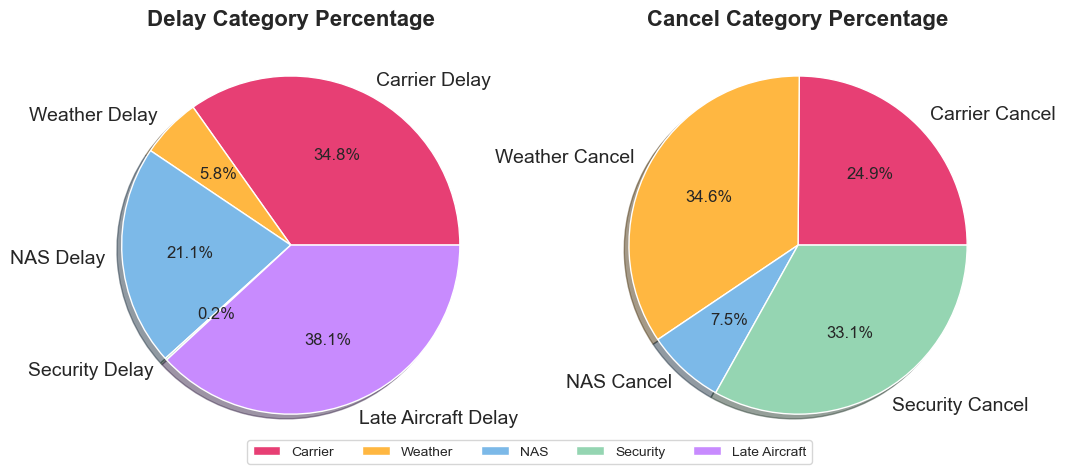

In [241]:
# Define a custom color palette
colors = ['#E73F74', '#FFB741', '#7CB9E8', '#95D5B2', '#C88BFE']

# Create the figure and axes
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)

# Create the first pie chart using the custom color palette and a shadow effect
wedges1, labels1, autopct1 = ax1.pie(total_delay_category['%Cause'], labels=['Carrier Delay', 'Weather Delay', 'NAS Delay', 'Security Delay', 'Late Aircraft Delay'], autopct='%.1f%%', colors=colors, shadow=True)

# Set the title and legend for the first chart
ax1.set_title("Delay Category Percentage", fontsize=16, weight='bold')
# ax1.legend(labels=['Carrier Delay', 'Weather Delay', 'NAS Delay', 'Security Delay', 'Late Aircraft Delay'], loc='center', bbox_to_anchor=(1, 0.5))

# Set the aspect ratio to 'equal' to make the pie chart circular for the first chart
ax1.set_aspect('equal')

# Create the second pie chart
wedges2, labels2, autopct2 = ax2.pie(total_cancel_category['%Cause'], labels=total_cancel_category.index, autopct='%.1f%%', colors=colors, shadow=True)

# Set the title and legend for the second chart
ax2.set_title("Cancel Category Percentage", fontsize=16, weight='bold')
# ax2.legend(labels=total_cancel_category.index, loc='center', bbox_to_anchor=(0, 0.5))

# Set the aspect ratio to 'equal' to make the pie chart circular for the second chart
ax2.set_aspect('equal')

# Set the text size for the labels and percentages
label_size = 14
percentage_size = 12
for ax, labels, autopct in zip([ax1, ax2], [labels1, labels2], [autopct1, autopct2]):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_zorder(1)
    for label in labels:
        label.set_size(label_size)
    for percentage in autopct:
        percentage.set_size(percentage_size)

# Add a legend for both charts
fig.legend(labels=['Carrier', 'Weather', 'NAS', 'Security', 'Late Aircraft'], loc='center', bbox_to_anchor=(0.5, 0.15), ncol=5)

# Show the plot
plt.show()



#### Airports

In [ ]:
# Create the Airport Codes DF

airport_viz = viz_df[['Origin', 'OriginCityName']].copy()
# get only the Unique Origin Airport Codes
airport_viz = airport_viz.drop_duplicates(subset=['Origin'])
# Split City and State to create columns for Table

airport_viz[['Airport_City','Airport_State']] = airport_viz['OriginCityName'].str.split(', ',expand=True)
# Remove unnecesary Column

airport_viz = airport_viz.drop(columns=['OriginCityName'])
# Clean the index

airport_viz.reset_index(drop=True,inplace=True)

In [ ]:
highest_delay_origin_airport = viz_delay_df.loc[viz_delay_df['DepDelayMinutes']>0].groupby('Origin').count()['count'].sort_values(ascending=False)
highest_cancel_origin_airport = cancelled_viz.groupby('Origin').count()['count'].sort_values(ascending=False)

highest_delay_dest_airport = viz_delay_df.loc[viz_delay_df['ArrDelayMinutes']>0].groupby('Dest').count()['count'].sort_values(ascending=False)
highest_cancel_dest_airport = cancelled_viz.groupby('Dest').count()['count'].sort_values(ascending=False)

In [119]:
airport_viz['Dep_Delay_Count']=airport_viz['Origin'].apply(lambda x: highest_delay_origin_airport[x] if x in highest_delay_origin_airport else None)
airport_viz['Arr_Delay_Count']=airport_viz['Origin'].apply(lambda x: highest_delay_dest_airport[x] if x in highest_delay_dest_airport else None)
airport_viz['Dep_Cancellation_Count']=airport_viz['Origin'].apply(lambda x: highest_cancel_origin_airport[x] if x in highest_cancel_origin_airport else None)
airport_viz['Arr_Cancellation_Count']=airport_viz['Origin'].apply(lambda x: highest_cancel_dest_airport[x] if x in highest_cancel_dest_airport else None)

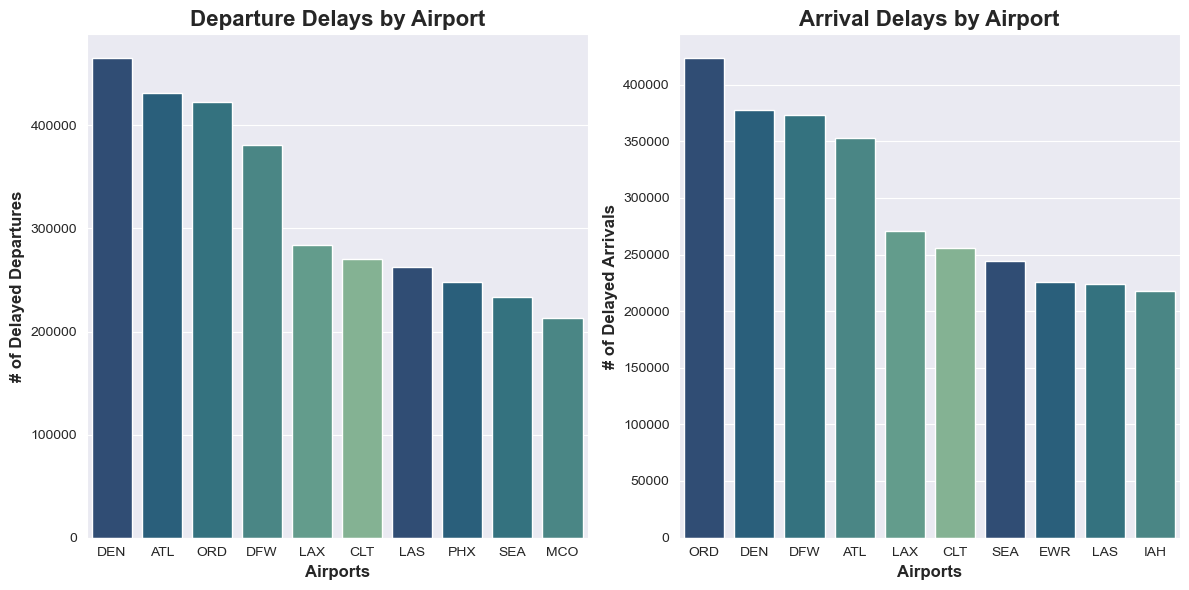

In [212]:
airport_viz_del_dep = pd.DataFrame()
airport_viz_del_dep[['Dep_Delay_Count','Origin']] = airport_viz[['Dep_Delay_Count','Origin']].sort_values(by='Dep_Delay_Count',ascending=False).head(10)
airport_viz_del_arr = pd.DataFrame()
airport_viz_del_arr[['Arr_Delay_Count','Origin']] = airport_viz[['Arr_Delay_Count','Origin']].sort_values(by='Arr_Delay_Count',ascending=False).head(10)


# Set the style to a cool theme
sns.set_style('darkgrid')

# Set the palette to "crest"
palette = sns.color_palette('crest_r')
sns.set_palette(palette)

# Create the figure and axes
fig, axes = plt.subplots(ncols=2, figsize=(12, 6))

# Create the first barplot
sns.barplot(x='Origin', y='Dep_Delay_Count', data=airport_viz_del_dep, ax=axes[0], palette=palette)
axes[0].set_xlabel('Airports', fontsize=12, weight='bold')
axes[0].set_ylabel('# of Delayed Departures', fontsize=12, weight='bold')
axes[0].set_title('Departure Delays by Airport', fontsize=16, weight='bold')

# Create the second barplot
sns.barplot(x='Origin', y='Arr_Delay_Count', data=airport_viz_del_arr, ax=axes[1], palette=palette)
axes[1].set_xlabel('Airports', fontsize=12, weight='bold')
axes[1].set_ylabel('# of Delayed Arrivals', fontsize=12, weight='bold')
axes[1].set_title('Arrival Delays by Airport', fontsize=16, weight='bold')

# Set the tick label font size for both plots
for ax in axes:
    ax.tick_params(axis='both', labelsize=10)

# Adjust the layout to prevent overlapping labels
fig.tight_layout()

# Show the plot
plt.show()



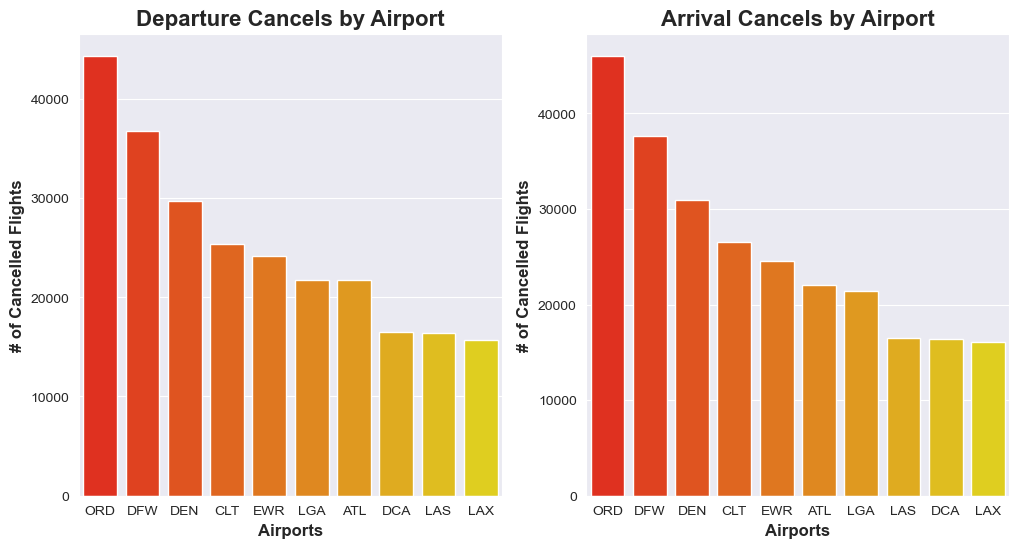

In [215]:
airport_viz_can_dep = pd.DataFrame()
airport_viz_can_dep[['Dep_Cancellation_Count','Origin']] = airport_viz[['Dep_Cancellation_Count','Origin']].sort_values(by='Dep_Cancellation_Count',ascending=False).head(10)

airport_viz_can_arr = pd. DataFrame()
airport_viz_can_arr[['Arr_Cancellation_Count','Origin']] = airport_viz[['Arr_Cancellation_Count','Origin']].sort_values(by='Arr_Cancellation_Count',ascending=False).head(10)


# Set the style 
sns.set_style('darkgrid')

# Create the figure and axes
fig, axes = plt.subplots(ncols=2,figsize=(12, 6))

# Plot the bar chart with the custom color palette
sns.barplot(x='Origin', y='Arr_Cancellation_Count', data=airport_viz_can_arr, ax=axes[1], palette='autumn')
# Plot the bar chart with the custom color palette
sns.barplot(x='Origin', y='Dep_Cancellation_Count', data=airport_viz_can_dep, ax=axes[0], palette='autumn')
# Set the axis[0] labels and title
axes[1].set_xlabel('Cancelled Arrival Airports', fontsize=12, weight='bold')
axes[1].set_ylabel('# of Flights', fontsize=12, weight='bold')
axes[1].set_title('Arrival Cancels by Airport', fontsize=16, weight='bold')
# Set the axis[1] labels and title
axes[0].set_xlabel('Cancelled Departure Airports', fontsize=12, weight='bold')
axes[0].set_ylabel('# of Flights', fontsize=12, weight='bold')
axes[0].set_title('Departure Cancels by Airport', fontsize=16, weight='bold')



for ax in axes:
    # Set the tick label font size
    ax.tick_params(axis='both', labelsize=10)

# Show the plot
plt.show()

#### Airlines

In [48]:
# Highest delayed airlines
highest_delayed_airlines = pd.DataFrame(viz_delay_df.groupby('Description').count()['count'].sort_values(ascending=False))

# Highest delayed airlines
highest_cancelled_airlines = pd.DataFrame(cancelled_viz.groupby('Description').count()['count'].sort_values(ascending=False))


,count
Description,
Southwest Airlines Co.,2718975
American Airlines Inc.,1335382
Delta Air Lines Inc.,1219165
SkyWest Airlines Inc.,1102428
United Air Lines Inc.,989413
JetBlue Airways,523399
Republic Airlines,424145
Envoy Air,403705
Alaska Airlines Inc.,382525


In [ ]:

Carrier_Cancel_by_Carrier =cancelled_viz.loc[cancelled_viz['CancellationCode']=='A'].groupby('Description')['count'].count()
Weather_Cancel_by_Carrier =cancelled_viz.loc[cancelled_viz['CancellationCode']=='B'].groupby('Description')['count'].count()
NAS_Cancel_by_Carrier =cancelled_viz.loc[cancelled_viz['CancellationCode']=='C'].groupby('Description')['count'].count()
Security_Cancel_by_Carrier =cancelled_viz.loc[cancelled_viz['CancellationCode']=='D'].groupby('Description')['count'].count()


Description
Air Wisconsin Airlines Corp                   2202
Alaska Airlines Inc.                         13063
Allegiant Air                                 4797
American Airlines Inc.                       24839
Cape Air                                         1
Capital Cargo International                   1883
Comair Inc.                                   4211
Commutair Aka Champlain Enterprises, Inc.     1100
Compass Airlines                               290
Delta Air Lines Inc.                         13747
Empire Airlines Inc.                           787
Endeavor Air Inc.                             2239
Envoy Air                                     2070
ExpressJet Airlines Inc.                      1710
Frontier Airlines Inc.                        5842
GoJet Airlines, LLC d/b/a United Express      1006
Hawaiian Airlines Inc.                        1083
Horizon Air                                   6105
JetBlue Airways                               8576
Mesa Airlines Inc. 

In [ ]:
Carrier_Delay_sum_airline = viz_delay_df.groupby('Description').sum()['CarrierDelay']
Weather_Delay_sum_airline = viz_delay_df.groupby('Description').sum()['WeatherDelay']
NAS_Delay_sum_airline = viz_delay_df.groupby('Description').sum()['NASDelay']
Security_Delay_sum_airline = viz_delay_df.groupby('Description').sum()['SecurityDelay']


In [ ]:
airline_viz= pd.DataFrame()
airline_viz['Description'] = airline_table['Description']
airline_viz['Total_Delay_Count'] = airline_viz['Description'].apply(lambda x: highest_delayed_airlines['count'][x] if x in highest_delayed_airlines.index else 0)
airline_viz['CarrierDelayMinutesSum'] = airline_viz['Description'].apply(lambda x: Carrier_Delay_sum_airline[x] if x in Carrier_Delay_sum_airline.index else 0)
airline_viz['WeatherDelayMinutesSum'] = airline_viz['Description'].apply(lambda x: Weather_Delay_sum_airline[x] if x in Weather_Delay_sum_airline.index else 0)
airline_viz['NASDelayMinutesSum'] = airline_viz['Description'].apply(lambda x: NAS_Delay_sum_airline[x] if x in NAS_Delay_sum_airline.index else 0)
airline_viz['SecurityDelayMinutesSum'] = airline_viz['Description'].apply(lambda x: Security_Delay_sum_airline[x] if x in Security_Delay_sum_airline.index else 0)
airline_viz['Total_Cancel_Count'] = airline_viz['Description'].apply(lambda x: highest_cancelled_airlines['count'][x] if x in highest_cancelled_airlines.index else 0)
airline_viz['CarrierCancelCount'] = airline_viz['Description'].apply(lambda x: Carrier_Cancel_by_Carrier[x] if x in Carrier_Cancel_by_Carrier.index else 0)
airline_viz['WeatherCancelCount'] = airline_viz['Description'].apply(lambda x: Weather_Cancel_by_Carrier[x] if x in Weather_Cancel_by_Carrier.index else 0)
airline_viz['NASCancelCount'] = airline_viz['Description'].apply(lambda x: NAS_Cancel_by_Carrier[x] if x in NAS_Cancel_by_Carrier.index else 0)
airline_viz['SecurityCancelCount'] = airline_viz['Description'].apply(lambda x: Security_Cancel_by_Carrier[x] if x in Security_Cancel_by_Carrier.index else 0)

In [392]:
airline_viz.columns

Index(['Description', 'Total_Delay_Count', 'CarrierDelayMinutesSum',
       'WeatherDelayMinutesSum', 'NASDelayMinutesSum',
       'SecurityDelayMinutesSum', 'Total_Cancel_Count', 'CarrierCancelCount',
       'WeatherCancelCount', 'NASCancelCount', 'SecurityCancelCount'],
      dtype='object')

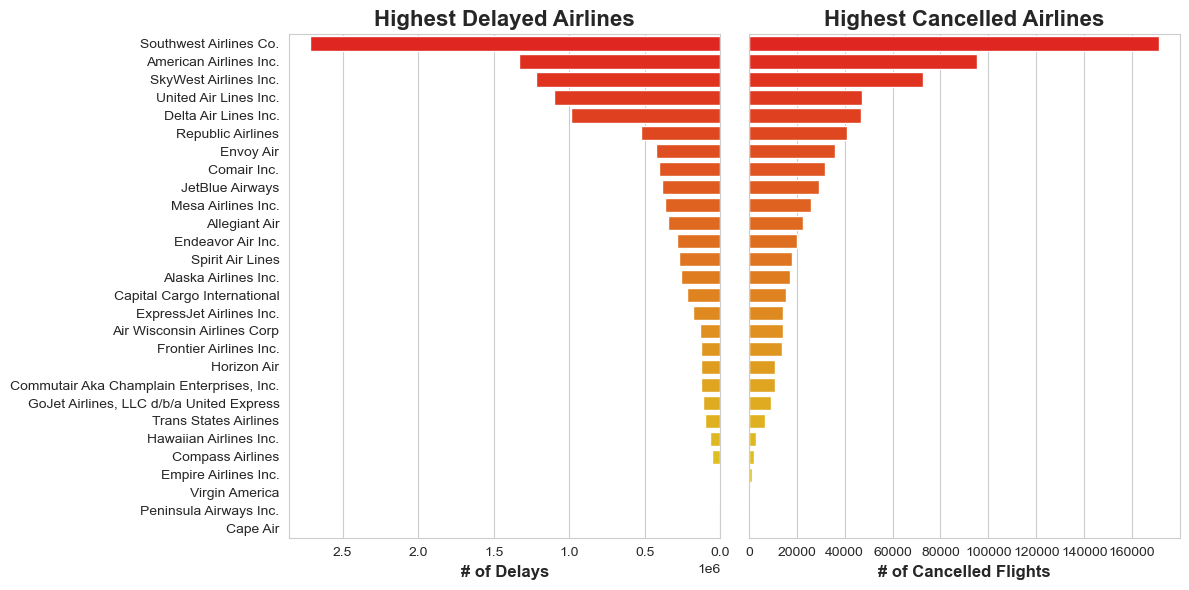

In [391]:
# Set the style to a Seaborn style
sns.set_style('whitegrid')

# Create the figure and axes
fig, axes = plt.subplots(ncols=2, figsize=(12, 6), sharey=True, gridspec_kw={'width_ratios': [1, 1]})

# Create the first horizontal bar plot using Seaborn
sns.barplot(x='count', y=highest_delayed_airlines.index, data=highest_delayed_airlines, palette='autumn', ax=axes[0])

# Invert the y-axis to show airlines from top to bottom
axes[0].invert_xaxis()

# Set the axis labels and title for the first plot
axes[0].set_xlabel('# of Delays', fontsize=12, weight='bold')
axes[0].set_ylabel('')
axes[0].set_title('Highest Delayed Airlines', fontsize=16, weight='bold')

# Create the second horizontal bar plot using Seaborn
sns.barplot(x='count', y=highest_cancelled_airlines.index, data=highest_cancelled_airlines, palette='autumn', ax=axes[1])

# Invert the y-axis to show airlines from top to bottom
# axes[1].invert_yaxis()

# Set the axis labels and title for the second plot
axes[1].set_xlabel('# of Cancelled Flights', fontsize=12, weight='bold')
axes[1].set_ylabel('')
axes[1].set_title('Highest Cancelled Airlines', fontsize=16, weight='bold')

# Set the tick label font size for both plots
for ax in axes:
    ax.tick_params(axis='both', labelsize=10)

# Align the y-axis labels to the center of the plot
fig.align_ylabels()

# Adjust the layout to prevent overlapping labels
fig.tight_layout()

# Show the plot
plt.show()


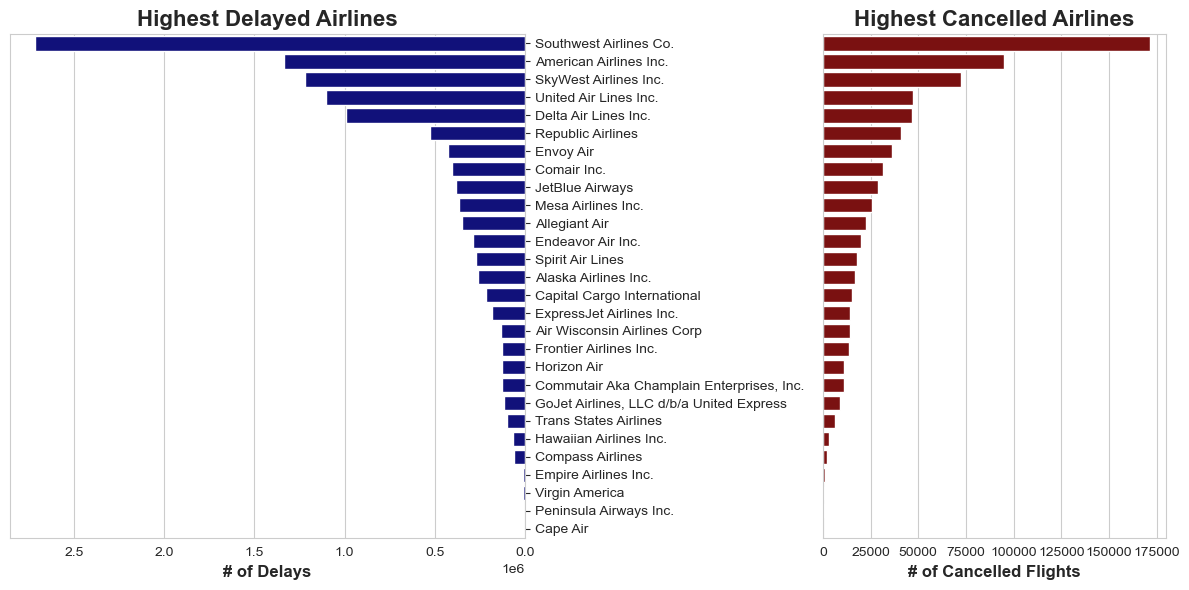

In [229]:
# Set the style to a Seaborn style
sns.set_style('whitegrid')

# Create the figure and axes
fig, axes = plt.subplots(ncols=2, figsize=(12, 6), sharey=True, gridspec_kw={'width_ratios': [1.5, 1]})

# Create the first horizontal bar plot using Seaborn
sns.barplot(x='count', y=highest_delayed_airlines.index, data=highest_delayed_airlines, color='darkblue', ax=axes[0])

# Invert the y-axis to show airlines from top to bottom
axes[0].invert_xaxis()

# Set the axis labels and title for the first plot
axes[0].set_xlabel('# of Delays', fontsize=12, weight='bold')
axes[0].set_ylabel('')
axes[0].set_title('Highest Delayed Airlines', fontsize=16, weight='bold')

# Move the y-axis labels to the right side of the first plot
axes[0].yaxis.tick_right()
axes[0].yaxis.set_label_position("right")

# Create the second horizontal bar plot using Seaborn
sns.barplot(x='count', y=highest_cancelled_airlines.index, data=highest_cancelled_airlines, color='darkred', ax=axes[1])


# Set the axis labels and title for the second plot
axes[1].set_xlabel('# of Cancelled Flights', fontsize=12, weight='bold')
axes[1].set_ylabel('')
axes[1].set_title('Highest Cancelled Airlines', fontsize=16, weight='bold')

# Set the tick label font size for both plots
for ax in axes:
    ax.tick_params(axis='both', labelsize=10)

# Align the y-axis labels to the center of the plot
fig.align_ylabels('center')

# Adjust the layout to prevent overlapping labels
fig.tight_layout()

# Show the plot
plt.show()


In [401]:
highest_airline_delay= airline_viz[['Description','Total_Delay_Count']].sort_values(by='Total_Delay_Count',ascending=False)

,Description,Total_Delay_Count
1463,Southwest Airlines Co.,2718975
142,American Airlines Inc.,1335382
484,Delta Air Lines Inc.,1219165
1007,SkyWest Airlines Inc.,1102428
1368,United Air Lines Inc.,989413
...,...,...
524,Eagle Jet Charter,0
523,Eagle Airline,0
522,Trans Europ. Airways France,0
521,Executive Four Winds,0


In [411]:
cancel_carrier_5 = airline_viz.sort_values(by='CarrierCancelCount',ascending=False)[['Description','CarrierCancelCount']].head(5)
cancel_weather_5 = airline_viz.sort_values(by='WeatherCancelCount',ascending=False)[['Description','WeatherCancelCount']].head(5)
cancel_NAS_5 = airline_viz.sort_values(by='NASCancelCount',ascending=False)[['Description','NASCancelCount']].head(5)
cancel_security_5 = airline_viz.sort_values(by='SecurityCancelCount',ascending=False)[['Description','SecurityCancelCount']].head(5)

NameError: name 'df1' is not defined

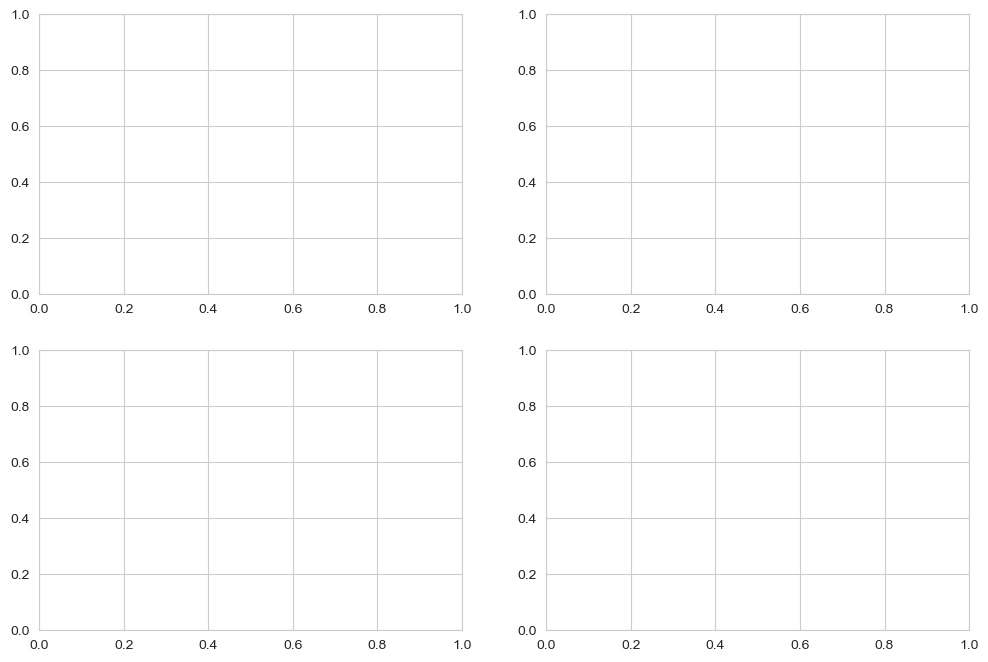

In [417]:
# Create a figure with four subplots arranged in a 2x2 grid
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Plot the first chart in the top-left subplot
sns.scatterplot(x='x1', y='y1', data=df1, ax=axes[0, 0])

# Plot the second chart in the top-right subplot
sns.lineplot(x='x2', y='y2', data=df2, ax=axes[0, 1])

# Plot the third chart in the bottom-left subplot
sns.barplot(x='x3', y='y3', data=df3, ax=axes[1, 0])

# Plot the fourth chart in the bottom-right subplot
sns.boxplot(x='x4', y='y4', data=df4, ax=axes[1, 1])

# Add a main title to the figure
fig.suptitle('Four Charts in One Visualization')

# Adjust the layout of the subplots to prevent overlapping
plt.tight_layout()

# Display the plot
plt.show()

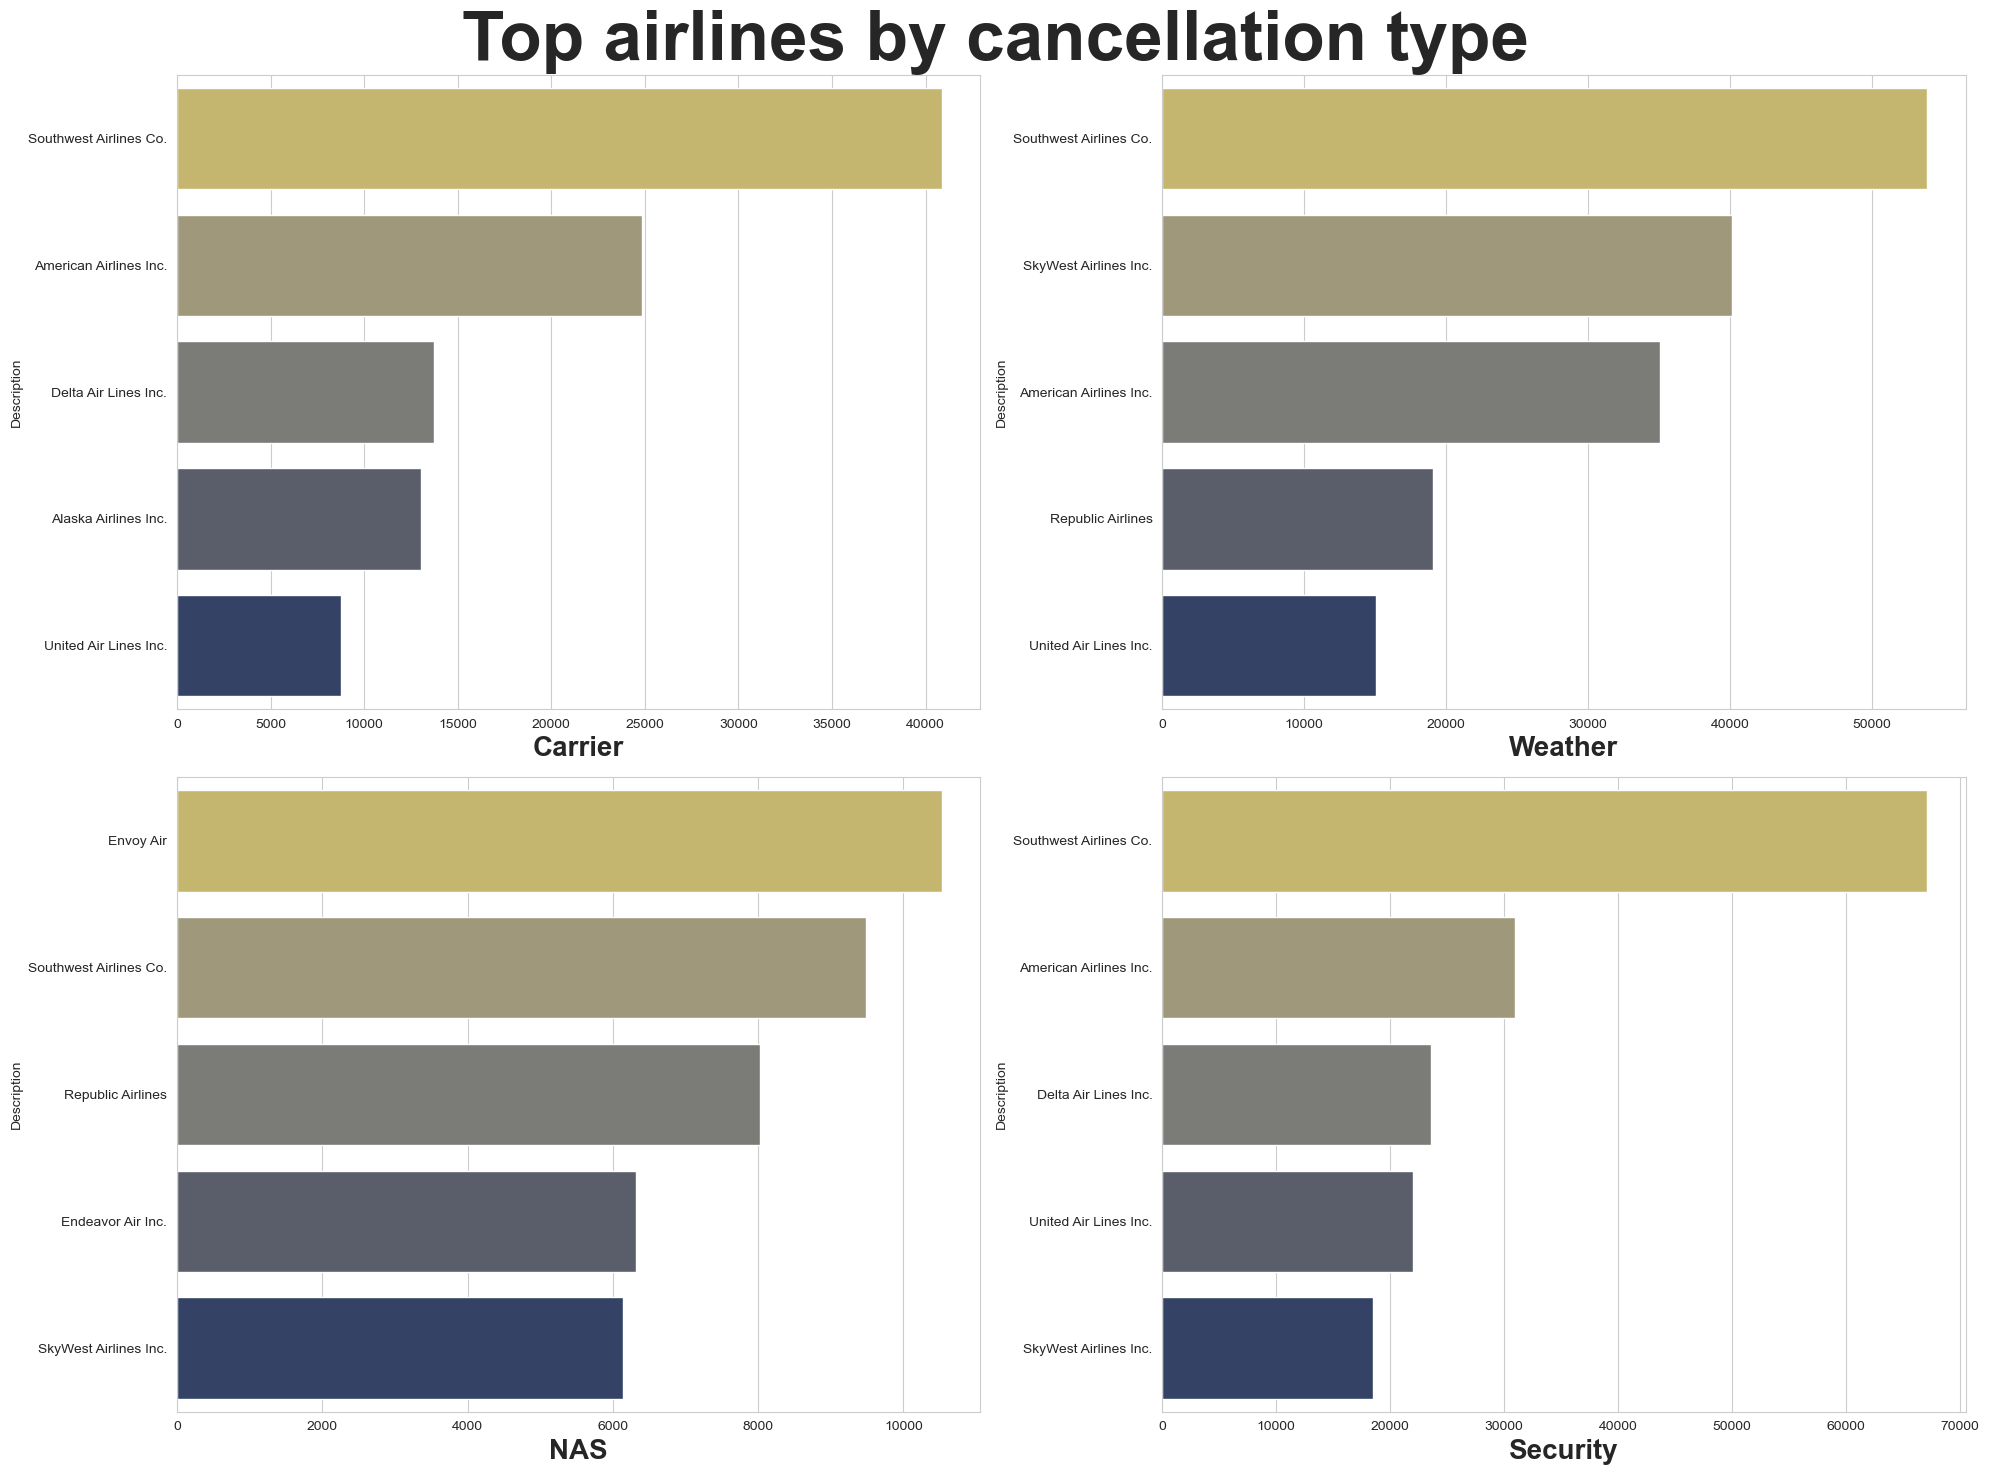

In [444]:
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(20,15))

plt.suptitle('Top airlines by cancellation type',weight='bold',fontsize='50')

sns.barplot(y='Description',x='CarrierCancelCount',data=cancel_carrier_5,ax=axes[0,0], palette='cividis_r') 

axes[0,0].set_xlabel('Carrier',fontsize='20',weight='bold')

sns.barplot(y='Description',x='WeatherCancelCount',data=cancel_weather_5,ax=axes[0,1], palette='cividis_r') 

axes[0,1].set_xlabel('Weather',fontsize='20',weight='bold')

sns.barplot(y='Description',x='NASCancelCount',data=cancel_NAS_5,ax=axes[1,0], palette='cividis_r') 

axes[1,0].set_xlabel('NAS',fontsize='20',weight='bold')

sns.barplot(y='Description',x='SecurityCancelCount',data=cancel_security_5,ax=axes[1,1], palette='cividis_r') 

axes[1,1].set_xlabel('Security',fontsize='20',weight='bold')

plt.tight_layout()

plt.show()
